In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.optimize
import pandas.io.sql as psql
import pandas as pd
import sys
sys.path.insert(0,'C:\Users\Sean Violante\Documents\Projects\lendico\lib')
import dwh
from __future__ import division

In [2]:
%matplotlib qt

In [3]:
conn = dwh.get_DWH()

In [4]:
excluded_loans=(3,4,6,8,11,14,526,528,558,630,557,556,555,553,552,554,578,579,580,603,596,611,642)
print(" hello {}".format(excluded_loans))

 hello (3, 4, 6, 8, 11, 14, 526, 528, 558, 630, 557, 556, 555, 553, 552, 554, 578, 579, 580, 603, 596, 611, 642)


In [23]:
excluded_loans="(-1)"

In [24]:
payment_plans_combined_sql="""SELECT pp.dwh_country_id, pp.fk_loan, pp.fk_loan_request,l.loan_nr as loan_request_nr, 
        pp.fk_user_investor, pp.fk_user_borrower, pp.country_name, 
        pp.nominal_interest_percentage, pp.promo_interest_percentage, pp.has_promo_flag, 
        pp.is_repaid_flag, 
        pp.payout_date, pp.interval, pp.interval_payback_date, pp.next_interval_payback_date, 
        pp.loan_coverage, 
    
        pp.payment_amount_borrower,
        sum(pp.payment_amount_borrower) OVER wind as payment_amount_borrower_cum,
        
        pp.principal_amount_borrower, 
        sum(pp.principal_amount_borrower) OVER wind as principal_amount_borrower_cum,
        
        pp.interest_amount_borrower,
        sum(pp.interest_amount_borrower) OVER wind as interest_amount_borrower_cum,
        
        pp.initial_principal_amount_borrower, 
        pp.residual_interest_amount_borrower, pp.residual_principal_amount_borrower, 
        
        pp.calc_service_fee, 
        
        pp.payment_amount_investor, 
        sum(pp.payment_amount_investor) OVER wind as payment_amount_investor_cum,
        
        pp.principal_amount_investor, 
        sum(pp.principal_amount_investor) OVER wind as principal_amount_investor_cum,
        
        pp.interest_amount_investor, 
        sum(pp.interest_amount_investor) OVER wind as interest_amount_investor_cum,
        
        pp.initial_principal_amount_investor, pp.sum_interval_interest_amount_investor, 
        pp.residual_interest_amount_investor, pp.residual_principal_amount_investor
    
        
        FROM base.loan_payment_plan_combined_item pp
        join base.loan l on (pp.dwh_country_id=l.dwh_country_id and pp.fk_loan=l.id_loan )
        join base.loan_funding lf on (pp.dwh_country_id=lf.dwh_country_id and pp.fk_loan=lf.fk_loan and pp.fk_user_investor=lf.fk_user)
        where pp.dwh_country_id=1 and 
        l.state!='canceled' 
        and l.id_loan not in {} and 
        l.originated_since is not null and
        lf.state='funded' and 
        pp.interval_payback_date<=current_date
        WINDOW wind as (PARTITION BY pp.dwh_country_id, pp.fk_loan, pp.fk_user_investor order by interval)
        """.format(excluded_loans)

# load german combined payment plan up to system date (very large), removing cancelled/non funded loans and loans created by lendico 'borrowers'

In [26]:
payment_plans_sql="""select 
pp.dwh_country_id, pp.fk_loan_payment_plan, pp.fk_user, pp.fk_loan_request, pp.fk_loan, 
pp.country_name, pp.currency_code, pp.loan_request_creation_date, 
interval, payment_amount, pp.interest_amount, pp.principal_amount, interval_payback_date, next_interval_payback_date, 
initial_principal_amount, sum_interval_interest_amount, residual_interest_amount, residual_principal_amount
from base.loan_payment_plan_item pp
join base.loan l on          (pp.dwh_country_id=l.dwh_country_id and pp.fk_loan=l.id_loan )
where pp.dwh_country_id=1 and l.state!='canceled'  and l.originated_since is not null
and l.id_loan not in {}""".format(excluded_loans)
# load german borrower payment plan , removing cancelled, not yet originated  loans and loans created by lendico 'borrowers'


In [27]:
loans_sql="""select l.*, gblrc.credit_agency_score, gblrc.pd, gblrc.pd_original, gblrc.lgd, gblrc.in_arrears_since, 
lp.state as payback_state
from base.loan l
join il.global_borrower_loan_requests_cohort gblrc
on (l.dwh_country_id=gblrc.dwh_country_id and l.loan_nr=gblrc.loan_request_nr)

join base.loan_payback lp
on (l.dwh_country_id=lp.dwh_country_id and l.id_loan=lp.fk_loan)
where 
    l.dwh_country_id=1 and 
    l.state!='canceled' and 
    id_loan not in {} and 
    originated_since is not null""".format(excluded_loans)


# load loans removing cancelled, not yet originated  loans and loans created by lendico 'borrowers'

In [38]:
actual_payments_combined_sql="""
with 
actual_payments as (select 
dp.dwh_country_id, dp.fk_user as fk_user_borrower, dp.fk_loan, dp.loan_request_nr
 ,dp.iso_date 
 ,dp.expected_amount_cum, dp.actual_amount_cum, in_arrears_flag, dp.in_arrears_since
 ,in_arrears_since_days
 
,dp.expected_amount_cum - lag(expected_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan  order by dp.iso_date)  expected_amount_month
,dp.actual_amount_cum - lag(actual_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan order by iso_date)
 actual_amount_month
 from base.de_payments dp
join base.loan_payback lp on (lp.dwh_country_id=dp.dwh_country_id and lp.fk_loan=dp.fk_loan) 

where dp.iso_date=(date_trunc('MONTH', dp.iso_date) + INTERVAL '1 MONTH - 1 day')::date
and (lp.state!='payback_complete' or lp.in_arrears_since is not null or dp.iso_date <=lp.last_payment_date)
and dp.fk_loan not in {}
) ,


actual_payments_cum as (
select 
ap.dwh_country_id, ap.fk_loan, 
-- dp.iso_date as date,min(pp.interval) as interval, min(interval_payback_date) interval_payback_date--, dp.actual_amount_cum, pp.payment_amount_cum'
ap.iso_date,max(pp.interval) as interval

from actual_payments ap

join 
(select dwh_country_id, fk_loan, interval, interval_payback_date, sum(payment_amount) OVER (partition by dwh_country_id,fk_loan order by interval) payment_amount_cum  from base.loan_payment_plan_item ) pp
on 
 (ap.dwh_country_id=pp.dwh_country_id and
 ap.fk_loan=pp.fk_loan and 
 ap.iso_date>=pp.interval_payback_date and
 ap.actual_amount_cum>=pp.payment_amount_cum )
 

group by ap.dwh_country_id, ap.fk_loan,  ap.iso_date 
--order by date, interval

),


 paymentplan as
(
        SELECT pp.dwh_country_id, pp.fk_loan, pp.fk_loan_request,  l.loan_nr as loan_request_nr,
        pp.fk_user_investor, pp.fk_user_borrower, pp.country_name, pp.nominal_interest_percentage, pp.promo_interest_percentage, pp.has_promo_flag, 
        pp.is_repaid_flag, pp.payout_date, pp.interval, pp.interval_payback_date, pp.next_interval_payback_date, pp.loan_coverage, 
        pp.payment_amount_borrower, pp.principal_amount_borrower, pp.interest_amount_borrower, pp.initial_principal_amount_borrower, pp.sum_interval_interest_amount_borrower, 
        pp.residual_interest_amount_borrower, pp.residual_principal_amount_borrower, pp.payment_amount_promo, pp.principal_amount_promo, pp.interest_amount_promo, pp.initial_principal_amount_promo, 
        pp.sum_interval_interest_amount_promo, pp.residual_interest_amount_promo, pp.residual_principal_amount_promo, pp.calc_service_fee,
        pp.payment_amount_investor, 
 
pp.principal_amount_investor, pp.interest_amount_investor, pp.initial_principal_amount_investor, pp.sum_interval_interest_amount_investor, 
        pp.residual_interest_amount_investor, pp.residual_principal_amount_investor
, sum(coalesce(payment_amount_investor,0) ) 
 OVER (partition by 
  pp.dwh_country_id, 
  pp.fk_loan, 
  pp.fk_user_investor
  ORDER BY pp.interval_payback_date)::float as payment_amount_investor_cum

 , sum(coalesce(pp.interest_amount_investor,0) ) 
 OVER (partition by 
  pp.dwh_country_id, 
  pp.fk_loan, 
  pp.fk_user_investor
  ORDER BY pp.interval_payback_date)::float as interest_amount_investor_cum

 , sum(coalesce(pp.principal_amount_investor,0) ) 
  OVER (partition by 
  pp.dwh_country_id, 
  pp.fk_loan, 
  pp.fk_user_investor
 ORDER BY pp.interval_payback_date)::float as principal_amount_investor_cum

        FROM base.loan_payment_plan_combined_item pp

 join   base.loan l    
 on     l.id_loan=pp.fk_loan and l.dwh_country_id=pp.dwh_country_id  
 join  base.loan_funding lf   on   
 pp.dwh_country_id=lf.dwh_country_id and pp.fk_loan=lf.fk_loan and pp.fk_user_investor=lf.fk_user
where pp.dwh_country_id=1 and lf.state='funded' and l.state!='canceled'
)



select 

 ap.dwh_country_id as dwh_country_id
 , ap.fk_user_borrower
 ,lf.fk_user as fk_user_investor
 , ap.fk_loan as fk_loan
 , ap.loan_request_nr
 , ap.iso_date,
 
 
pp.nominal_interest_percentage, pp.promo_interest_percentage, pp.has_promo_flag, 
pp.is_repaid_flag, pp.payout_date, pp.interval, pp.interval_payback_date, pp.next_interval_payback_date, pp.loan_coverage, 
pp.payment_amount_borrower, pp.principal_amount_borrower, pp.interest_amount_borrower, pp.initial_principal_amount_borrower, pp.sum_interval_interest_amount_borrower, 
pp.residual_interest_amount_borrower, pp.residual_principal_amount_borrower, pp.calc_service_fee,

pp.payment_amount_investor, pp.payment_amount_investor_cum,

pp.principal_amount_investor, pp.interest_amount_investor, pp.sum_interval_interest_amount_investor, 
pp.interest_amount_investor_cum,
pp.residual_interest_amount_investor,
 pp.principal_amount_investor_cum,
 pp.initial_principal_amount_investor, 
coalesce (pp.residual_principal_amount_investor, lf.amount) as residual_principal_amount_investor

,expected_amount_month, expected_amount_cum
,actual_amount_month, actual_amount_cum
, in_arrears_flag, in_arrears_since
 ,in_arrears_since_days  


from actual_payments ap
left join actual_payments_cum ap_cum 
   on( 
  ap.dwh_country_id=ap_cum.dwh_country_id and 
  ap.fk_loan=ap_cum.fk_loan and 
  ap.iso_date=ap_cum.iso_date
   )

join base.loan_funding lf on (
 ap.dwh_country_id=lf.dwh_country_id and
 ap.fk_loan=lf.fk_loan

)
   
left join paymentplan pp on (
    pp.dwh_country_id=ap.dwh_country_id and 
    pp.fk_user_investor = lf.fk_user and
    pp.fk_loan=ap.fk_loan and 
    ap_cum.interval=pp.interval) 
where  ap.dwh_country_id=1 and ap.iso_date <=current_date and lf.state='funded'

order by dwh_country_id,fk_loan,iso_date ;""".format(excluded_loans)


In [28]:
actual_payments_sql= """

 with 

actual_payments as (select 
dp.dwh_country_id, dp.fk_user as fk_user_borrower, dp.fk_loan, dp.loan_request_nr
 ,dp.iso_date 
 ,dp.expected_amount_cum, dp.actual_amount_cum, in_arrears_flag, dp.in_arrears_since
 ,in_arrears_since_days
-- expected/actual payment over month (by taking diff of cumsum)
,dp.expected_amount_cum - lag(expected_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan  order by dp.iso_date)  expected_amount_month
,dp.actual_amount_cum - lag(actual_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan order by iso_date)
 actual_amount_month
 from base.de_payments dp
 join base.loan_payback lp on (lp.dwh_country_id=dp.dwh_country_id and lp.fk_loan=dp.fk_loan) 
where dp.iso_date=(date_trunc('MONTH', dp.iso_date) + INTERVAL '1 MONTH - 1 day')::date
and (lp.state!='payback_complete' or lp.in_arrears_since is not null or dp.iso_date <=lp.last_payment_date)
and dp.fk_loan not in {0}
) ,
-- select End of month, excluding those that have now paid back ( apart from those that were paid back by lendico)


-- find corresponding payment plan item.
-- we find the maximum payment plan interval that has cum_payment<= actual_cum 
-- could also use distinct on?
-- match only actual payments that have happened after plan date
-- problem is overpayments [ ie where payment plan has not been updated with extra payment.. because 
actual_payments_cum as (
select 
ap.dwh_country_id, ap.fk_loan, 
-- dp.iso_date as date,min(pp.interval) as interval, min(interval_payback_date) interval_payback_date--, dp.actual_amount_cum, pp.payment_amount_cum'
ap.iso_date,max(pp.interval) as interval

from actual_payments ap

join 
(select dwh_country_id, fk_loan, interval, interval_payback_date, sum(payment_amount) \
    OVER (partition by dwh_country_id,fk_loan order by interval) payment_amount_cum  
    from base.loan_payment_plan_item ) pp
on 
 (ap.dwh_country_id=pp.dwh_country_id and
 ap.fk_loan=pp.fk_loan and 
 ap.iso_date>=pp.interval_payback_date and -- we need this to exclude extra payments that have not been added to payment plan
 ap.actual_amount_cum>=pp.payment_amount_cum )
 
group by ap.dwh_country_id, ap.fk_loan,  ap.iso_date 
--order by date, interval

),


 paymentplan as
(

SELECT pp.dwh_country_id, pp.fk_user, pp.fk_loan_request,pp.fk_loan, l.loan_nr, pp.country_name, interval,
payment_amount, pp.interest_amount
,pp.principal_amount,interval_payback_date,next_interval_payback_date,initial_principal_amount,
sum_interval_interest_amount,residual_interest_amount,residual_principal_amount
, sum(coalesce(payment_amount,0) ) 
 OVER W::float as payment_amount_cum

 , sum(coalesce(pp.interest_amount,0) ) 
 OVER W::float as interest_amount_cum

 , sum(coalesce(pp.principal_amount,0) ) 
  OVER W::float as principal_amount_cum

 FROM base.loan_payment_plan_item pp 
        

 join   base.loan l    
 on     l.id_loan=pp.fk_loan and l.dwh_country_id=pp.dwh_country_id  
 
WINDOW W as (partition by pp.dwh_country_id, pp.fk_loan ORDER BY pp.interval_payback_date)
)

select 

 
 ap.dwh_country_id as dwh_country_id
 , ap.fk_user_borrower
 , ap.fk_loan as fk_loan
 , ap.loan_request_nr as loan_nr --changed from pp.loan_nr
 , ap.iso_date
 , pp.interval
 , pp.interval_payback_date
,pp.payment_amount, pp.payment_amount_cum,

pp.principal_amount, pp.interest_amount, pp.sum_interval_interest_amount, 
pp.interest_amount_cum,
pp.residual_interest_amount,
 pp.principal_amount_cum,
 pp.initial_principal_amount, 
coalesce (pp.residual_principal_amount, l.principal_amount) as residual_principal_amount

,expected_amount_month, expected_amount_cum
,actual_amount_month, actual_amount_cum
, in_arrears_flag, in_arrears_since
 ,in_arrears_since_days  



from actual_payments ap
left join actual_payments_cum ap_cum 
   on( 
  ap.dwh_country_id=ap_cum.dwh_country_id and 
  ap.fk_loan=ap_cum.fk_loan and 
  ap.iso_date=ap_cum.iso_date
   )
  
left join paymentplan pp
 
on (pp.dwh_country_id=ap.dwh_country_id and 
        pp.fk_loan=ap.fk_loan and 
        ap_cum.interval=pp.interval)
join base.loan l 
on (ap.dwh_country_id=l.dwh_country_id and ap.fk_loan=l.id_loan)
where  ap.dwh_country_id=1 and ap.iso_date <=current_date and  ap.fk_loan not in {0} 

order by dwh_country_id,fk_loan,iso_date ;
""".format(excluded_loans)


In [29]:
loan_fundings_sql="""select * from base.loan_funding where dwh_country_id=1 
and fk_loan not in {} and state='funded'""".format(excluded_loans)

In [30]:
loans[loans.id_loan==625].state

NameError: name 'loans' is not defined

In [33]:
%time loans=psql.read_sql(loans_sql,conn)

Wall time: 7.98 s


In [34]:
%time loan_fundings=psql.read_sql(loan_fundings_sql,conn)

Wall time: 24.5 s


In [32]:
%time payment_plans=psql.read_sql(payment_plans_sql,conn)

Wall time: 41.2 s


In [31]:
%time payment_plans_combined=psql.read_sql(payment_plans_combined_sql,conn)

Wall time: 2min 40s


In [35]:
%time actual_payments=psql.read_sql(actual_payments_sql,conn)

Wall time: 11.9 s


In [39]:
%time actual_payments_combined=psql.read_sql(actual_payments_combined_sql,conn)

Wall time: 4min 41s


In [40]:
loans['rating_base']=loans.rating.str[0]
loans['originated_since_date']=np.array(loans.originated_since,'datetime64[D]')
loans['rating_switch']=1 + \
    (loans['originated_since_date']>np.datetime64('2014-06-30')) + \
    (loans['originated_since_date']>np.datetime64('2014-10-14'))

In [41]:
loan_fundings1=loan_fundings.merge(loans[['id_loan','originated_since_date','principal_amount']],left_on=['fk_loan'],right_on=['id_loan'])

In [42]:
loan_fundings1['loan_coverage1']=loan_fundings1.amount/loan_fundings1.principal_amount*100

In [19]:
loans.originated_since_date[loans['rating_switch']==3].head()

317   2014-10-23
394   2014-10-23
402   2014-10-29
403   2014-10-16
407   2014-12-03
Name: originated_since_date, dtype: datetime64[ns]

In [402]:
payment_plans_combined.shape

(168353, 36)

In [123]:
actual_payments[actual_payments.fk_loan==33]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,interval,interval_payback_date,payment_amount,payment_amount_cum,principal_amount,...,initial_principal_amount,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days,in_arrears_since_days_30360
336,1,2383,33,NaN,2014-02-28,NaN,None,NaN,NaN,NaN,...,NaN,2000.0000,10.49,10.49,10.48,10.48,1,2014-02-15,13,13
337,1,2383,33,613940189,2014-03-31,0,2014-02-15,10.49,10.49,0.0000,...,2000.0000,2000.0000,90.99,101.48,90.99,101.47,1,2014-03-15,16,16
338,1,2383,33,613940189,2014-04-30,1,2014-03-15,90.99,101.48,76.6933,...,2000.0000,1923.3067,90.99,192.47,90.99,192.46,1,2014-04-15,15,15
339,1,2383,33,613940189,2014-05-31,2,2014-04-15,90.99,192.47,77.2384,...,1923.3067,1846.0683,90.99,283.46,90.99,283.45,1,2014-05-15,16,16
340,1,2383,33,613940189,2014-06-30,3,2014-05-15,90.99,283.46,77.7906,...,1846.0683,1768.2777,90.99,374.45,90.99,374.44,1,2014-06-15,15,15
341,1,2383,33,613940189,2014-07-31,4,2014-06-15,90.99,374.45,78.3468,...,1768.2777,1689.9309,90.99,465.44,90.99,465.43,1,2014-07-15,16,16
342,1,2383,33,613940189,2014-08-31,5,2014-07-15,90.99,465.44,78.9070,...,1689.9309,1611.0239,90.99,556.43,90.99,556.42,1,2014-08-15,16,16
343,1,2383,33,613940189,2014-09-30,6,2014-08-15,90.99,556.43,79.4712,...,1611.0239,1531.5527,90.99,647.42,90.99,647.41,1,2014-09-15,15,15
344,1,2383,33,613940189,2014-10-31,7,2014-09-15,90.99,647.42,80.0394,...,1531.5527,1451.5133,90.99,738.41,90.99,738.40,1,2014-10-15,16,16
345,1,2383,33,613940189,2014-11-30,7,2014-09-15,90.99,647.42,80.0394,...,1531.5527,1451.5133,90.99,829.40,0.00,738.40,1,2014-10-15,46,45


In [25]:
np.histogram(a1.pay_diff,bins=[-100,-10,-1,0,1,2,10,100,1000,2000,5000])

(array([  0,   0,   0,  27,  15,  22,  73, 219,  17,   6]),
 array([-100,  -10,   -1,    0,    1,    2,   10,  100, 1000, 2000, 5000]))

In [24]:
a1=actual_payments[actual_payments.in_arrears_flag==1].copy()
a1['pay_diff']=a1['expected_amount_cum']-a1['actual_amount_cum']
a1['pay_diff%']=a1['pay_diff']/a1['payment_amount']*100


In [143]:
(23+17+24)/392

0.16326530612244897

In [139]:
a1.sort('pay_diff')[['iso_date','fk_loan','interval','payment_amount','expected_amount_cum','pay_diff','pay_diff%']].head(80)


,iso_date,fk_loan,interval,payment_amount,expected_amount_cum,pay_diff,pay_diff%
2740,2015-01-31,264,1,80.89,3075.79,0.01,0.012362
2741,2015-02-28,264,1,80.89,3075.79,0.01,0.012362
2742,2015-03-31,264,1,80.89,3075.79,0.01,0.012362
2743,2015-04-30,264,1,80.89,3075.79,0.01,0.012362
2739,2014-12-31,264,1,80.89,3075.79,0.01,0.012362
2737,2014-10-31,264,1,80.89,3075.79,0.01,0.012362
2738,2014-11-30,264,1,80.89,3075.79,0.01,0.012362
344,2014-10-31,33,7,90.99,738.41,0.01,0.010990
339,2014-05-31,33,2,90.99,283.46,0.01,0.010990
338,2014-04-30,33,1,90.99,192.47,0.01,0.010990


In [146]:
z1=pd.DataFrame(actual_payments.set_index(['iso_date','fk_loan'])[['in_arrears_since', 'in_arrears_since_days']])
z1['bucket']=np.ceil(z1.in_arrears_since_days/30)
a1=z1.bucket.unstack()

a2=a1.shift(-1, freq='M')
a3=a1.shift(-2, freq='M')
a4=a1.shift(-3, freq='M')
a5=a1.shift(-4, freq='M')
a6=a1.shift(-5, freq='M')
a7=a1.shift(-6, freq='M')


z1['in_arrears_since_1M']=a2.stack()
z1['in_arrears_since_2M']=a3.stack()
z1['in_arrears_since_3M']=a4.stack()
z1['in_arrears_since_4M']=a5.stack()
z1['in_arrears_since_5M']=a6.stack()
z1['in_arrears_since_6M']=a7.stack()



In [ ]:
# trying to detemine stability 

In [148]:
z2=z1.fillna(0)

In [150]:
z3=z2.groupby(['bucket','in_arrears_since_1M']).size()

In [37]:
def days360_tup(diff):
    # not actually 30360 as in bond basis. 
    # note february -> 30 so longer ( and 31 months get shortened)
    x=None
    try:
        x=(diff[1].year-diff[0].year)*360+(diff[1].month-diff[0].month)*30+min((diff[1].day-diff[0].day),30)
    except AttributeError:
        pass
    return x
       
def days360(start,end):
    diffs=zip(start,end)
    
    return map(days360_tup, diffs)

def rebase(x):
    # we treat interval 0 as special ( can't default then)
    # might consider doing fractional amount
    # if first interval is zero, return x otherwise x-x[0]+1
    return x-x.iloc[0]+(x.iloc[0]>0)

def calc_survival(pp):
    # outputs new dataframe
    pp=pp.copy()
    pp['interval_rebased']=pp[['fk_loan','interval']].groupby('fk_loan').transform(rebase)
    
    pp['surv_month']=(1-pp.pd).pow(1/12.0)
    pp['survive'] =pp.surv_month.pow(pp.interval_rebased)
    pp['default'] =(pp.interval_rebased>0) * pp.surv_month.pow(pp.interval_rebased-1) * (1-pp.surv_month)
    pp['e_payment_amount']=pp.survive * pp.payment_amount
    pp['e_recovery']=pp.default * pp.recovery*pp.initial_principal_amount
    pp['e_tot']=pp.e_payment_amount + pp.e_recovery
    pp['e_tot_svc']=pp['e_tot']*(1-0.01)
    return pp

def make_pd_arrears( act_pay, loans, latest_date,arrears_dict):
    act_pay=act_pay[np.array(act_pay.iso_date,'datetime64[D]')==np.datetime64(latest_date,'D')].copy()
    act_pay['bucket']=np.ceil(act_pay.in_arrears_since_days_30360/30)*30
    act_pay['bucket_pd']=act_pay.bucket.map(arrears_dict)
    
    return loans.merge(act_pay[['fk_loan','in_arrears_since', 'in_arrears_since_days',\
                                'in_arrears_since_days_30360', 'bucket', 'bucket_pd']], \
                       left_on='id_loan',right_on='fk_loan',how='left')
    
def add_pd(pp, loans, use_in_arrears):
    """ add pd from loans, divide by 100, and create dupl pd_noarr """
    pp_pd=pp.merge(loans[['id_loan','pd','bucket_pd']],left_on='fk_loan',right_on='id_loan')
    pp_pd['pd']=pp_pd['pd']/100.0
    pp_pd['pd_noarr']=pp_pd['pd']
    if use_in_arrears:
        pp_pd.loc[pp_pd.bucket_pd.notnull(),'pd']=pp_pd.loc[pp_pd.bucket_pd.notnull(),'bucket_pd']
    return pp_pd                

def make_future_pd(payment_plans, actual_payments,loans, EOM_date_str, latest_paid_interval, arrears_dict, use_in_arrears):
    """ 
        select future payments ( after EOM_date_str)
        for each loan remove payment_plans where already paid
    """
    fut=payment_plans[payment_plans.interval_payback_date > \
                      datetime.datetime.strptime(EOM_date_str,'%Y-%m-%d').date()].merge(\
                        pd.DataFrame(latest_paid_interval),left_on='fk_loan',right_index=True,how='left')
    fut=fut[(fut.latest_paid_interval.isnull() )|(fut.interval>fut.latest_paid_interval)]
    # drop intervals already in actual???
    fut_pd=add_pd(fut, loans, use_in_arrears)
    fut_pd=calc_survival(fut_pd)
    return fut_pd
    
def generate_cashflows(pp, actual,loans):
    # take payments and add initial principal
    cashflows=pp[['fk_loan','e_tot']].copy()
    cashflows['interval_payback_date']=np.array(pp.interval_payback_date,'datetime64[D]')
    cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','e_tot':'payment'},inplace=True)
    # ids=cashflows.id_loan.unique()
    loans_orig=loans[['id_loan','originated_since_date','principal_amount']].copy()
    loans_orig.principal_amount=-loans_orig.principal_amount
    
    
    loans_orig.rename(columns={'originated_since_date':'date' ,'principal_amount':'payment'},inplace=True)
    act=actual[['fk_loan','iso_date','actual_amount_month']].\
        rename(columns={'fk_loan':'id_loan','iso_date':'date','actual_amount_month':'payment'}).copy()
    act.date=np.array(act.date,'datetime64[D]')
    cashflows=act.append([cashflows,loans_orig],ignore_index=True)
    cashflows['dcf']=(np.datetime64('2015-04-01','D')  -cashflows["date"].values)/np.timedelta64(1,'D')/365
    cashflows=cashflows.merge(loans[['id_loan','rating_base','rating_switch','payback_state']],on='id_loan',how='left')
    return cashflows


def generate_cashflows_pp(pp,loan_fundings,loans):
    # generate cashflows from plan for xirr ( by taking payment amount, loan funding and residual principal
    # exclude loans for which no plan yet or interval zero where 
    cashflows=pp[['fk_loan','fk_user_investor','interval_payback_date','payment_amount_investor']].copy()
    cashflows['interval_payback_date']=np.array(pp.interval_payback_date,'datetime64[D]') 
    
    cashflows=cashflows[cashflows.payment_amount_investor.notnull()]
    
    investor_loan_ids=cashflows[['fk_loan','fk_user_investor']].drop_duplicates()
    # filter out cases with no plan yet ( depends on investor because first payment could be <1 cent)
    cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','payment_amount_investor':'payment'},inplace=True)
    loan_fundings=loan_fundings[['fk_loan','fk_user','originated_since_date','amount']]\
        .merge(investor_loan_ids,left_on=['fk_loan','fk_user'],right_on=['fk_loan','fk_user_investor'])
    del loan_fundings['fk_user_investor']
    loan_fundings.amount=-loan_fundings.amount
    loan_fundings.rename(columns={'fk_loan':'id_loan', 'fk_user':'fk_user_investor','originated_since_date':'date' ,'amount':'payment'},inplace=True)
    
    residuals=pp[['fk_loan','fk_user_investor','interval_payback_date','residual_principal_amount_investor']]\
        .groupby(['fk_loan','fk_user_investor']).agg({\
                                'interval_payback_date':np.max,\
                                'residual_principal_amount_investor':np.min}).reset_index()
    # should be same as finding principal at max date!
    residuals=residuals[residuals.residual_principal_amount_investor.notnull()]
    
    residuals.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date' ,\
                              'residual_principal_amount_investor':'payment'},inplace=True)    
    cashflows=cashflows.append([loan_fundings, residuals],ignore_index=True)
    #cashflows['date']=np.array(cashflows.date,'datetime64[D]')
    cashflows['dcf']=(datetime.date(2015,4,1)  -cashflows['date'])/np.timedelta64(1,'D')/365
    cashflows=cashflows.merge(loans[['id_loan','rating_base','rating_switch','payback_state']],on='id_loan',how='left')
    return cashflows

def xnpv(rs,amounts, taus):
    """ should work for scalars and vectors. 
    taus: is the day count fraction as of the valuation date (tau=0)
    """
    qs=np.power(1+rs ,taus)
    return np.sum(amounts*qs)

def xirr(amounts,taus, guess=0.1):
    # RuntimeError: Failed to converge after 50 iterations, value is nan
    try:
        z=scipy.optimize.newton(lambda r: xnpv(r,amounts, taus),guess)
    except RuntimeError:
        z=np.nan
    return z

# merge in investor field and loan coverage, change borrower payment to investor cashflow ( ie according to their allocation of loan) 
def add_investor_coverage(cashflows,loan_fundings):
    cashflows1=cashflows.merge(loan_fundings[['fk_loan','fk_user','loan_coverage1']],left_on='id_loan',right_on='fk_loan')
    cashflows1['orig_payment']=cashflows1['payment']
    cashflows1['payment']=cashflows1['orig_payment']*cashflows1['loan_coverage1']/100.0
    return cashflows1


In [38]:
actual_payments['in_arrears_since_days_30360']=days360(actual_payments.in_arrears_since.values,actual_payments.iso_date.values)


In [142]:
actual_payments.columns

Index([u'dwh_country_id', u'fk_user_borrower', u'fk_loan', u'loan_nr', u'iso_date', u'interval', u'interval_payback_date', u'payment_amount', u'payment_amount_cum', u'principal_amount', u'interest_amount', u'sum_interval_interest_amount', u'interest_amount_cum', u'residual_interest_amount', u'principal_amount_cum', u'initial_principal_amount', u'residual_principal_amount', u'expected_amount_month', u'expected_amount_cum', u'actual_amount_month', u'actual_amount_cum', u'in_arrears_flag', u'in_arrears_since', u'in_arrears_since_days', u'in_arrears_since_days_30360'], dtype='object')

In [39]:
irreg_payments_sql="select * from backend.loan_payment_plan where plan ~* 'IRREGULAR' and dwh_country_id=1"
# problem with like '%irregular%#

In [40]:
irreg_payments=psql.read_sql_query(irreg_payments_sql,conn)

In [51]:
irreg_payments.columns

Index([u'dwh_country_id', u'id_loan_payment_plan', u'fk_user', u'fk_loan', u'interval_payment', u'last_interval_payment', u'plan', u'created_at', u'updated_at', u'dwh_created', u'dwh_last_modified', u'country', u'dwh_row_hash'], dtype='object')

In [62]:
cols=irreg_payments.columns.values.tolist()
cols.remove('plan')
cols


[u'dwh_country_id',
 u'id_loan_payment_plan',
 u'fk_user',
 u'fk_loan',
 u'interval_payment',
 u'last_interval_payment',
 u'created_at',
 u'updated_at',
 u'dwh_created',
 u'dwh_last_modified',
 u'country',
 u'dwh_row_hash']

In [69]:
z=pd.read_json(irreg_payments.plan[0])

In [77]:
z.loc[:,cols[0]]=0

In [79]:
li=[]
cols=irreg_payments.columns.values.tolist()
cols.remove('plan')

for i in range(irreg_payments.shape[0]):
    z=pd.read_json(irreg_payments.plan[i])
    for c in cols:
        z.loc[:,c]=irreg_payments.iloc[i][c]
    li.append(z)

irreg_p=pd.concat(li)

In [81]:
irreg_p.fk_loan.unique()

array([ 20,  28,  51, 241,  65,  92, 264, 360, 135, 324, 334, 270,  37,
       354, 253, 579, 311, 168,  58, 232, 379,  41, 366, 422, 764, 860,
        77,  30, 498,  76,  71, 378, 507, 419, 552, 526, 580, 349,  27,
        19,  98, 553, 557, 630, 817, 400, 480, 256, 267, 528, 269, 735,
        33, 394, 571, 904, 138, 132, 408, 323,  94], dtype=int64)

In [367]:
def pplan(pay):
    z=pd.read_json(pay.plan)
    z[

,accumulatedInterestAmount,initialPrincipalAmount,interestAmount,interestDays,interval,intervalPaybackDate,intervalType,paymentAmount,principalAmount,residualPrincipalAmount,sumIntervalInterestAmount
0,0.0000,800000.0000,6644.4444,26,0,2014-02-15,INITIAL,6644.4444,0.0000,800000.0000,6644.4444
1,0.0000,800000.0000,7666.6667,30,1,2014-03-15,REGULAR,26381.0000,18714.3333,781285.6667,14311.1111
2,0.0000,781285.6667,7487.3210,30,2,2014-04-15,REGULAR,26381.0000,18893.6790,762391.9877,21798.4321
3,0.0000,762391.9877,7306.2565,30,3,2014-05-15,REGULAR,26381.0000,19074.7435,743317.2442,29104.6886
4,0.0000,743317.2442,7123.4569,30,4,2014-06-15,REGULAR,26381.0000,19257.5431,724059.7011,36228.1455
5,2312.9685,724059.7011,0.0000,10,5,2014-06-25,IRREGULAR,10000.0000,10000.0000,714059.7011,36228.1455
6,0.0000,714059.7011,6875.0166,30,6,2014-07-15,REGULAR,26381.0000,19505.9834,694553.7177,43103.1621
7,0.0000,694553.7177,6656.1398,30,7,2014-08-15,REGULAR,26381.0000,19724.8602,674828.8575,49759.3019
8,0.0000,674828.8575,6467.1099,30,8,2014-09-15,REGULAR,26381.0000,19913.8901,654914.9674,56226.4118
9,0.0000,654914.9674,6276.2684,30,9,2014-10-15,REGULAR,26381.0000,20104.7316,634810.2358,62502.6802


In [41]:
actual_payments['cum_diff']=actual_payments.expected_amount_cum-actual_payments.actual_amount_cum

In [332]:
actual_payments[abs(actual_payments.cum_diff)>0.01].to_clipboard()

In [146]:
actual_payments.shape

(7194, 26)

## select fewer columns in payment plan. create sum amount column


In [26]:
rm_l=[u'eur_payment_amount', u'eur_interest_amount', u'eur_principal_amount', u'eur_initial_principal_amount', u'eur_sum_interval_interest_amount', u'eur_residual_interest_amount', u'eur_residual_principal_amount', u'created_at', u'updated_at', u'dwh_created', u'dwh_last_modified']

In [27]:
for l in rm_l[1:]:
    del payment_plans[l]

In [24]:
payment_plans.columns

Index([u'dwh_country_id', u'fk_loan_payment_plan', u'fk_user', u'fk_loan_request', u'fk_loan', u'country_name', u'currency_code', u'loan_request_creation_date', u'interval', u'payment_amount', u'interest_amount', u'principal_amount', u'interval_payback_date', u'next_interval_payback_date', u'initial_principal_amount', u'sum_interval_interest_amount', u'residual_interest_amount', u'residual_principal_amount', u'eur_payment_amount', u'eur_interest_amount', u'eur_principal_amount', u'eur_initial_principal_amount', u'eur_sum_interval_interest_amount', u'eur_residual_interest_amount', u'eur_residual_principal_amount', u'created_at', u'updated_at', u'dwh_created', u'dwh_last_modified'], dtype='object')

In [45]:
payment_plans.sort(['fk_loan','interval'],inplace=True) #prob unnecc? but need sorted for rebase

In [42]:
def recovery(amounts):
    return 0.1425+(0.2613-.1425)*(amounts<=25000)+ (0.5814 - 0.2613)*(amounts<=5000)
    # losses return 0.4186+(0.7387-.4186)*(amounts>5000)+ (0.8575 - 0.7387)*(amounts>25000)

In [64]:
actual_payments.columns

Index([u'dwh_country_id', u'fk_user_borrower', u'fk_loan', u'loan_nr', u'iso_date', u'interval', u'interval_payback_date', u'payment_amount', u'payment_amount_cum', u'principal_amount', u'interest_amount', u'sum_interval_interest_amount', u'interest_amount_cum', u'residual_interest_amount', u'principal_amount_cum', u'initial_principal_amount', u'residual_principal_amount', u'expected_amount_month', u'expected_amount_cum', u'actual_amount_month', u'actual_amount_cum', u'in_arrears_flag', u'in_arrears_since', u'in_arrears_since_days', u'in_arrears_since_days_30360'], dtype='object')

In [162]:
payment_plans_combined.columns

Index([u'dwh_country_id', u'fk_loan', u'fk_loan_request', u'loan_request_nr', u'fk_user_investor', u'fk_user_borrower', u'country_name', u'nominal_interest_percentage', u'promo_interest_percentage', u'has_promo_flag', u'is_repaid_flag', u'payout_date', u'interval', u'interval_payback_date', u'next_interval_payback_date', u'loan_coverage', u'payment_amount_borrower', u'payment_amount_borrower_cum', u'principal_amount_borrower', u'principal_amount_borrower_cum', u'interest_amount_borrower', u'interest_amount_borrower_cum', u'initial_principal_amount_borrower', u'residual_interest_amount_borrower', u'residual_principal_amount_borrower', u'calc_service_fee', u'payment_amount_investor', u'payment_amount_investor_cum', u'principal_amount_investor', u'principal_amount_investor_cum', u'interest_amount_investor', u'interest_amount_investor_cum', u'initial_principal_amount_investor', u'sum_interval_interest_amount_investor', u'residual_interest_amount_investor', u'residual_principal_amount_inves

In [165]:
payment_plans_combined[(payment_plans_combined.fk_loan==7) & (payment_plans_combined.fk_user_investor==38)].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
dwh_country_id,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
fk_loan,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
fk_loan_request,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148
loan_request_nr,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648,745156648
fk_user_investor,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
fk_user_borrower,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561
country_name,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany
nominal_interest_percentage,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69,5.69
promo_interest_percentage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
has_promo_flag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
loan_fundings1.head().T

,0,1,2,3,4
dwh_country_id,1,1,1,1,1
id_loan_funding,153,155,156,157,160
fk_loan,9,9,9,9,9
fk_loan_request,20,20,20,20,20
fk_user,547,574,582,613,642
country_name,Germany,Germany,Germany,Germany,Germany
currency_code,EUR,EUR,EUR,EUR,EUR
loan_request_creation_date,2013-12-01 00:00:00,2013-12-01 00:00:00,2013-12-01 00:00:00,2013-12-01 00:00:00,2013-12-01 00:00:00
amount,50,25,100,100,200
investment_yield,3.1259,3.1259,3.1259,3.1259,3.1276


In [46]:
payment_plans['recovery']=recovery(payment_plans.initial_principal_amount)

In [47]:
latest_paid_interval=actual_payments.groupby('fk_loan')['interval'].max()
latest_paid_interval.name='latest_paid_interval'

In [48]:
arrears_dict={30:0.15,60:0.35, 90:0.67, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.195, 60: 0.44, 90:0.611, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.164, 60: 0.384, 90:0.55, 120:1,150:1,180:1,210:1,240:1,270:1}




In [219]:
future_pd_30360[future_pd_30360.fk_loan==85].to_clipboard()

In [49]:
loans1=make_pd_arrears( actual_payments, loans, latest_date='2015-04-30',arrears_dict=arrears_dict)

In [274]:
a1=cashflows_pp[(cashflows_pp.id_loan==1618)].sort('date',inplace=False)
a1

,id_loan,fk_user_investor,date,payment,dcf,rating_base,rating_switch,payback_state
193859,1618,1415,2015-04-15,-25,-0.038356,D,3,payback_pending
193890,1618,49104,2015-04-15,-25,-0.038356,D,3,payback_pending
193891,1618,52513,2015-04-15,-100,-0.038356,D,3,payback_pending
193892,1618,56175,2015-04-15,-100,-0.038356,D,3,payback_pending
193893,1618,57045,2015-04-15,-25,-0.038356,D,3,payback_pending
193894,1618,57405,2015-04-15,-25,-0.038356,D,3,payback_pending
193895,1618,65725,2015-04-15,-50,-0.038356,D,3,payback_pending
193896,1618,68055,2015-04-15,-50,-0.038356,D,3,payback_pending
193897,1618,69210,2015-04-15,-25,-0.038356,D,3,payback_pending
193898,1618,72602,2015-04-15,-50,-0.038356,D,3,payback_pending


In [152]:

arrears_dict

{30: 0.195,
 60: 0.44,
 90: 0.611,
 120: 1,
 150: 1,
 180: 1,
 210: 1,
 240: 1,
 270: 1}

In [50]:
future_pd_30360_arrears=make_future_pd(payment_plans, actual_payments,loans1, '2015-04-30',latest_paid_interval, arrears_dict,True)
future_pd_30360_origpd=make_future_pd(payment_plans, actual_payments,loans1, '2015-04-30',latest_paid_interval, arrears_dict,False)

In [252]:
cashflows_fut_bucket=generate_cashflows(future_pd,actual_payments,loans)

In [313]:
cashflows_pp=generate_cashflows_pp(payment_plans_combined,loan_fundings1,loans)

In [303]:
payment_plans_combined[(payment_plans_combined.fk_loan==1819) & (payment_plans_combined.interval==0)].T

,166704,166705,166706,166707,166708,166709,166710,166711
dwh_country_id,1,1,1,1,1,1,1,1
fk_loan,1819,1819,1819,1819,1819,1819,1819,1819
fk_loan_request,83798,83798,83798,83798,83798,83798,83798,83798
loan_request_nr,334609435,334609435,334609435,334609435,334609435,334609435,334609435,334609435
fk_user_investor,424,9246,25151,33769,45025,81876,89763,103730
fk_user_borrower,101748,101748,101748,101748,101748,101748,101748,101748
country_name,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany
nominal_interest_percentage,3.15,3.15,3.15,3.15,3.15,3.15,3.15,3.15
promo_interest_percentage,0,0,0,0,0,0,0,0
has_promo_flag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
a=cashflows_pp[(cashflows_pp.id_loan==304)].sort('date',inplace=False)
a.to_clipboard()

In [322]:
a=cashflows_fut_bucket_30360_origpd[cashflows_fut_bucket_30360_origpd.id_loan==304].sort('date',inplace=False)
a.to_clipboard()

In [344]:
a=cashflows_fut_bucket_30360_arrears[cashflows_fut_bucket_30360_arrears.id_loan==33].sort('date',inplace=False)
a.to_clipboard()
a

,date,id_loan,payment,dcf,rating_base,rating_switch,payback_state
84828,2014-01-21,33,-2000.000000,1.191781,D,1,payback
325,2014-02-28,33,10.480000,1.087671,D,1,payback
326,2014-03-31,33,90.990000,1.002740,D,1,payback
327,2014-04-30,33,90.990000,0.920548,D,1,payback
328,2014-05-31,33,90.990000,0.835616,D,1,payback
329,2014-06-30,33,90.990000,0.753425,D,1,payback
330,2014-07-31,33,90.990000,0.668493,D,1,payback
331,2014-08-31,33,90.990000,0.583562,D,1,payback
332,2014-09-30,33,90.990000,0.501370,D,1,payback
333,2014-10-31,33,90.990000,0.416438,D,1,payback


In [337]:
cashflows_fut_bucket_30360_arrears=generate_cashflows(future_pd_30360_arrears,actual_payments,loans)
cashflows_fut_bucket_30360_origpd=generate_cashflows(future_pd_30360_origpd,actual_payments,loans)

In [370]:
print loans_fut_xirr.shape
print loans_xirr.shape

(1592L,)
(1623L,)


In [345]:
actual_payments[actual_payments.fk_loan==33]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,interval,interval_payback_date,payment_amount,payment_amount_cum,principal_amount,...,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days,in_arrears_since_days_30360,cum_diff
325,1,2383,33,613940189,2014-02-28,NaN,None,NaN,NaN,NaN,...,2000.0000,10.49,10.49,10.48,10.48,1,2014-02-15,13,13,0.01
326,1,2383,33,613940189,2014-03-31,0,2014-02-15,10.49,10.49,0.0000,...,2000.0000,90.99,101.48,90.99,101.47,1,2014-03-15,16,16,0.01
327,1,2383,33,613940189,2014-04-30,1,2014-03-15,90.99,101.48,76.6933,...,1923.3067,90.99,192.47,90.99,192.46,1,2014-04-15,15,15,0.01
328,1,2383,33,613940189,2014-05-31,2,2014-04-15,90.99,192.47,77.2384,...,1846.0683,90.99,283.46,90.99,283.45,1,2014-05-15,16,16,0.01
329,1,2383,33,613940189,2014-06-30,3,2014-05-15,90.99,283.46,77.7906,...,1768.2777,90.99,374.45,90.99,374.44,1,2014-06-15,15,15,0.01
330,1,2383,33,613940189,2014-07-31,4,2014-06-15,90.99,374.45,78.3468,...,1689.9309,90.99,465.44,90.99,465.43,1,2014-07-15,16,16,0.01
331,1,2383,33,613940189,2014-08-31,5,2014-07-15,90.99,465.44,78.9070,...,1611.0239,90.99,556.43,90.99,556.42,1,2014-08-15,16,16,0.01
332,1,2383,33,613940189,2014-09-30,6,2014-08-15,90.99,556.43,79.4712,...,1531.5527,90.99,647.42,90.99,647.41,1,2014-09-15,15,15,0.01
333,1,2383,33,613940189,2014-10-31,7,2014-09-15,90.99,647.42,80.0394,...,1451.5133,90.99,738.41,90.99,738.40,1,2014-10-15,16,16,0.01
334,1,2383,33,613940189,2014-11-30,7,2014-09-15,90.99,647.42,80.0394,...,1451.5133,90.99,829.40,0.00,738.40,1,2014-10-15,46,45,91.00


In [348]:
actual_payments[actual_payments.cum_diff<-50].to_clipboard()

In [255]:
loans_fut_bucket_xirr=cashflows_fut_bucket.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [341]:
loans_fut_xirr_arrears=cashflows_fut_bucket_30360_arrears.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))
loans_fut_xirr_origpd=cashflows_fut_bucket_30360_origpd.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [342]:
loans_xirr=pd.DataFrame({'plan':loan_pp_xirr,'origpd':loans_fut_xirr_origpd, 'inarr':loans_fut_xirr_arrears})
loans_xirr=loans_xirr.merge(loans1[['id_loan','principal_amount','payback_state','pd','bucket_pd','rating','rating_switch']],\
                            left_index=True,right_on='id_loan')
loans_xirr.to_clipboard()

In [256]:
loans_fut_bucket_xirr_groups=cashflows_fut_bucket[cashflows_fut_bucket.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [39]:
loans_fut_bucket_30360_xirr_groups=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [93]:
loans_fut_bucket_30360_xirr_origpd=cashflows_fut_bucket_30360_origpd[cashflows_fut_bucket_30360_origpd.payback_state!='payback_complete'].groupby(['rating_switch']).apply(lambda x: xirr(x.payment,x.dcf))

In [95]:
loans_fut_bucket_30360_xirr_origpd*100

rating_switch
1                3.585695
2                5.184321
3                3.881436
dtype: float64

In [139]:
investor_cashflows_fut_bucket_30360=add_investor_coverage(cashflows_fut_bucket_30360,loan_fundings1)
investor_cashflows_fut_bucket_30360_origpd=add_investor_coverage(cashflows_fut_bucket_30360_origpd,loan_fundings1)


In [259]:
investor_fut_bucket_30360_xirr=investor_cashflows_fut_bucket_30360[investor_cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['fk_user']).apply(lambda x: xirr(x.payment,x.dcf))
investor_fut_bucket_30360_xirr_origpd=investor_cashflows_fut_bucket_30360_origpd[investor_cashflows_fut_bucket_30360_origpd.payback_state!='payback_complete'].groupby(['fk_user']).apply(lambda x: xirr(x.payment,x.dcf))



In [316]:
investor_pp_xirr=cashflows_pp[cashflows_pp.payback_state!='payback_complete'].groupby(['fk_user_investor']).apply(lambda x: xirr(x.payment,x.dcf))
loan_pp_xirr=cashflows_pp.groupby(['id_loan']).apply(lambda x: xirr(x.payment,x.dcf))

In [262]:
investor_pp_xirr.index.name='fk_user'

In [295]:
investor_xirr=pd.DataFrame(
    {'plan':investor_pp_xirr,
        'origpd':investor_fut_bucket_30360_xirr_origpd, 'inarr':investor_fut_bucket_30360_xirr})


investors=loan_fundings1.groupby('fk_user').agg({'amount':np.sum, 'fk_loan':'count'})
investor_xirr=investor_xirr.merge(investors,left_index=True,right_index=True)
investor_xirr.to_clipboard()

In [122]:
cnt,bns=np.histogram(investor_fut_bucket_30360_xirr_orig, bins=np.linspace(-.5,.5,101))
a=pd.DataFrame({'bin':bns[:-1], 'count':cnt})
a.to_clipboard()
a

,bin,count
0,-0.50,0
1,-0.49,0
2,-0.48,0
3,-0.47,0
4,-0.46,0
5,-0.45,0
6,-0.44,0
7,-0.43,0
8,-0.42,0
9,-0.41,0


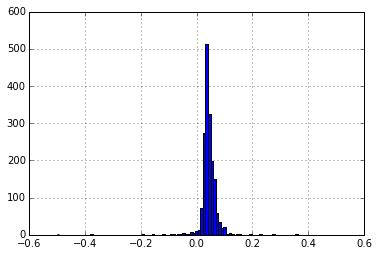

In [187]:
investor_fut_bucket_30360_xirr_orig.hist(bins=np.linspace(-.5,.5,110))

In [197]:
(investor_fut_bucket_30360_xirr_orig[investor_fut_bucket_30360_xirr_orig<0]*100).sort(inplace=False)

fk_user
10109     -37.459966
34054     -19.200474
10860     -15.587540
43106     -11.646885
18565      -9.395938
39596      -8.292229
1051       -6.674273
57196      -6.615652
10875      -6.033690
21689      -5.237668
21616      -5.237668
70380      -5.207702
34979      -4.757932
30313      -4.374064
27499      -4.374064
30250      -4.374064
23793      -4.374064
74370      -3.311351
73515      -3.185728
52551      -2.955957
25480      -2.583975
30245      -2.283771
138        -2.171029
20702      -1.932459
45815      -1.900109
75380      -1.867716
19633      -1.668579
6122       -1.646010
16137      -1.308895
55239      -0.931836
1835       -0.928396
23775      -0.903602
73709      -0.681998
73537      -0.378624
670        -0.031558
18621      -0.016670
dtype: float64

In [205]:
inv_count,inv_bin=np.histogram(investor_fut_bucket_30360_xirr_orig,bins=np.linspace(-.5,.5,101))


In [207]:
inv_hist=pd.DataFrame({'bin':inv_bin[:-1],'count':inv_count})

In [208]:
inv_hist.to_clipboard()

In [43]:
%matplotlib inline

In [154]:
loans_fut_bucket_30360_xirr_orig*100

rating_switch
1                2.446569
2                3.991386
3                3.453717
dtype: float64

In [165]:
loans_fut_bucket_30360_xirr_orig*100 

rating_switch
1                2.915440
2                4.099140
3                3.495064
dtype: float64

In [47]:
z1=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete']

xirr(z1.payment, z1.dcf)

0.03470183916784976

In [42]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              2.164635
               B             -0.289620
               C              2.843701
               D              4.380164
               E              7.495481
2              A              2.336687
               B              3.229219
               C              4.145394
               D              5.631069
               E              7.443198
3              A              2.390730
               B              2.876238
               C              3.830051
               D              4.275146
               E              4.906416
dtype: float64

In [43]:
loans_fut_bucket_30360_xirr_groups.to_clipboard()

In [308]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [167]:
loans_fut_xirr_groups=cashflows_fut[cashflows_fut.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [246]:
loans_fut_xirr_groups*100

rating_switch  rating_base
1              A               2.318630
               B               2.276984
               C               3.590574
               D               5.797576
               E               7.664678
2              A               2.533089
               B               3.506267
               C               6.085838
               D               7.710767
               E               7.674173
3              A             -15.986781
               B             -15.818247
               C             -14.123845
               D             -11.749378
               E             -12.484912
dtype: float64

In [309]:
(loans_fut_bucket_xirr_groups*100)

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [168]:
loans_fut_bucket_xirr_groups=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))
(loans_fut_bucket_xirr_groups*100)

rating_switch  rating_base
1              A              2.317944
               B             -0.195389
               C              3.016421
               D              8.264013
               E              7.614183
2              A              2.525294
               B              3.289584
               C              4.318376
               D              5.665452
               E              7.526119
3              A              2.410894
               B              2.911874
               C              3.853142
               D              4.340949
               E              5.067028
dtype: float64

In [154]:
loans_fut_xirr=pd.DataFrame(loans_fut_xirr,columns=['irr'])
loans_fut_xirr_pb=loans_fut_xirr.merge(loans[['id_loan','payback_state']],left_index=True,right_on='id_loan',how='left')
loans_fut_xirr_pb.set_index('id_loan', inplace=True)

In [153]:
loans_fut_xirr1.head()

,irr,id_loan,payback_state
6,0.051250,7,payback
0,0.025000,9,payback
8,0.052125,10,payback
4,0.023063,12,payback
3,0.027797,13,payback


In [89]:
loans_fut_xirr[loans_fut_xirr>.2]


id_loan
51          1.550209
65          2.082980
71          1.026548
92          0.913007
98          0.921890
232         2.715411
253         2.530222
270         3.796371
304         0.236168
334         5.211220
349         2.898589
354         4.808944
366         3.689217
498         6.032595
507         5.509628
625         0.961159
860        68.781251
dtype: float64

In [103]:
loans_fut_xirr[loans_fut_xirr<-.2]

id_loan
27        -0.871503
76        -0.959543
449       -0.470978
dtype: float64

In [136]:
(loans_fut_xirr[loans_fut_xirr<.2]*100).hist(bins=100)

In [121]:
loans.state.value_counts()

payback                    1669
payout_pending                8
payout_approval_pending       2
dtype: int64

In [96]:
payment_plans[payment_plans.fk_loan==65]

,dwh_country_id,fk_loan_payment_plan,fk_user,fk_loan_request,fk_loan,country_name,currency_code,loan_request_creation_date,interval,payment_amount,interest_amount,principal_amount,interval_payback_date,next_interval_payback_date,initial_principal_amount,sum_interval_interest_amount,residual_interest_amount,residual_principal_amount,eur_payment_amount,recovery
2067,1,63,5527,3533,65,Germany,EUR,2014-01-29,1,549.32,92.0000,457.3200,2014-04-01,2014-04-17,12000.0000,92.0000,517.9653,11542.6800,549.32,0.2613
2068,1,63,5527,3533,65,Germany,EUR,2014-01-29,2,0.00,0.0000,0.0000,2014-04-17,2014-05-15,11542.6800,92.0000,517.9653,11542.6800,0.00,0.2613
2069,1,63,5527,3533,65,Germany,EUR,2014-01-29,3,549.32,129.7910,419.5290,2014-05-15,2014-06-15,11542.6800,221.7910,388.1743,11123.1510,549.32,0.2613
2070,1,63,5527,3533,65,Germany,EUR,2014-01-29,4,549.32,85.2775,464.0425,2014-06-15,2014-07-15,11123.1510,307.0685,302.8968,10659.1085,549.32,0.2613
2071,1,63,5527,3533,65,Germany,EUR,2014-01-29,5,549.32,81.7198,467.6002,2014-07-15,2014-08-15,10659.1085,388.7883,221.1770,10191.5083,549.32,0.2613
2072,1,63,5527,3533,65,Germany,EUR,2014-01-29,6,549.32,78.1349,471.1851,2014-08-15,2014-09-15,10191.5083,466.9232,143.0421,9720.3232,549.32,0.2613
2073,1,63,5527,3533,65,Germany,EUR,2014-01-29,7,549.32,74.5225,474.7975,2014-09-15,2014-10-14,9720.3232,541.4457,68.5196,9245.5257,549.32,0.2613
2074,1,63,5527,3533,65,Germany,EUR,2014-01-29,8,9314.05,68.5196,9245.5257,2014-10-14,2199-01-01,9245.5257,609.9653,0.0000,0.0000,9314.05,0.2613


In [122]:
np.histogram(payment_plans.payment_amount,bins=[0,1,5,10,20,100,500,1000])

(array([   70,   328,   263,   504, 17098, 60279,  7554]),
 array([   0,    1,    5,   10,   20,  100,  500, 1000]))

In [127]:
np.histogram(payment_plans.payment_amount[payment_plans.interval==0],bins=[0,1,5,10,20,100,500,1000])

(array([ 69, 328, 263, 383, 705,  60,   0]),
 array([   0,    1,    5,   10,   20,  100,  500, 1000]))

In [164]:
resid=payment_plans_idx.loc[idx[:,:,payment_plans_idx.index.get_level_values(2)<'2015-03-24']\
                        ,'residual_principal_amount'].groupby(level=(0,1)).nth(-1)
cashflows=payment_plans_idx.loc[idx[:,:,payment_plans_idx.index.get_level_values(2)<'2015-03-24'],'payment_amount']
cashflows1=cashflows.append([-loan_orig.principal_amount,resid])
cashflows2=pd.DataFrame(cashflows1)
cashflows2['dcf']=(np.datetime64('2015-03-24','D')-np.array(cashflows2.index.get_level_values(2).to_datetime(),dtype='datetime64[D]'))/np.timedelta64(1,'D')/365

In [255]:
cashflows=pd.DataFrame(payment_plans_pd.loc[~(payment_plans_pd.fk_loan.isin(miss_loans)),['fk_loan','interval_payback_date','e_tot']])
cashflows.interval_payback_date=np.array(cashflows.interval_payback_date,'datetime64[D]')
cashflows.e_tot*=(1-.01)
loans_orig=loans.loc[~(payment_plans_pd.fk_loan.isin(miss_loans)),['id_loan','originated_since','principal_amount']]
loans_orig.principal_amount=-loans_orig.principal_amount
loans_orig['originated_since_date']=np.array(loans_orig['originated_since'],'datetime64[D]')

cashflows1=cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','e_tot':'payment'})


In [169]:
cashflows.head()

,fk_loan,interval_payback_date,e_tot
0,7,2014-01-01,0.630000
1,7,2014-02-01,44.000624
2,7,2014-03-01,43.810256
3,7,2014-04-01,43.620712
4,7,2014-05-01,43.431988


In [256]:
principal_payments=loans_orig[['id_loan','originated_since_date' ,'principal_amount']].\
    rename(columns={'originated_since_date':'date' ,'principal_amount':'payment'})
cashflows2=cashflows1.append(principal_payments,ignore_index=True)
cashflows2["dcf"]=(np.datetime64('2015-03-24','D')  -cashflows2["date"].values)/np.timedelta64(1,'D')/365

In [257]:
cashflows2["dcf"]=(np.datetime64('2015-03-24','D')  -cashflows2["date"].values)/np.timedelta64(1,'D')/365

In [ ]:
cashflows2[cashflows2.id_loan==85]

In [258]:
cashflows2[cashflows2.id_loan==85]

,id_loan,date,payment,dcf
43329,966,2015-02-01,9.098100,0.139726
43330,966,2015-03-01,81.251575,0.063014
43331,966,2015-04-01,80.553800,-0.021918
43332,966,2015-05-01,79.860454,-0.104110
43333,966,2015-06-01,79.171508,-0.189041
43334,966,2015-07-01,78.486937,-0.271233
43335,966,2015-08-01,77.806712,-0.356164
43336,966,2015-09-01,77.130806,-0.441096
43337,966,2015-10-01,76.459193,-0.523288
43338,966,2015-11-01,75.791845,-0.608219


In [286]:
actual_payments[actual_payments.fk_loan==966]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,payment_amount,payment_amount_cum,principal_amount,interest_amount,sum_interval_interest_amount,...,principal_amount_cum,initial_principal_amount,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days
5343,1,73957,966,140346852,2015-02-28,9.19,9.19,0.000,9.1867,9.1867,...,0.000,3000,3000.000,9.19,9.19,9.19,9.19,0,NaN,NaN
5344,1,73957,966,140346852,2015-03-31,71.69,80.88,54.465,17.2250,26.4117,...,54.465,3000,2945.535,71.69,80.88,71.69,80.88,0,NaN,NaN


In [186]:
xirr(cashflows2.loc[cashflows2.id_loan==500,'payment'],cashflows2.loc[cashflows2.id_loan==500,'dcf'])*100

5.4735134310179845

In [100]:
miss_loans=set(loans.id_loan) ^ set(payment_plans.fk_loan) # symmetric difference

In [259]:
loans_xirr=cashflows2.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [215]:
mth3_loans=loans_orig.id_loan[loans_orig.originated_since_date<np.datetime64('2015-01-22')]

In [252]:
payment_plans_pd[payment_plans_pd.fk_loan==966].to_clipboard()

In [260]:

f=plt.figure(1)
f.clf()
(loans_xirr*100).hist()

In [207]:
loans[loans.id_loan==966].T

,991
dwh_country_id,1
id_loan,966
fk_loan_request,55818
fk_user,73957
fk_ranking,13143
country_name,Germany
currency_code,EUR
loan_request_creation_date,2015-01-07 00:00:00
user_age,55
loan_nr,140346852


In [251]:
(loans_xirr.loc[mth3_loans]*100).hist()

In [253]:
loans_xirr.loc[966]

0.03870272564140468

In [254]:
loans_orig[loans_orig.id_loan==966]

,id_loan,originated_since,principal_amount,originated_since_date
991,966,2015-01-15 15:27:19,-3000,2015-01-15


In [203]:
cashflows2[cashflows2.id_loan==966].sort('date').to_clipboard()

In [103]:
no0=set(payment_plans.fk_loan.unique()) - set( pp1.fk_loan.unique()) # checking if each loan has interval 0 
no0

{16,
 21,
 38,
 40,
 63,
 64,
 65,
 68,
 73,
 94,
 195,
 200,
 202,
 203,
 204,
 205,
 234,
 245,
 251,
 253,
 256,
 257,
 258,
 271,
 320,
 435,
 704,
 709,
 718,
 719,
 721,
 730,
 784,
 978,
 1502,
 1602,
 1618,
 1625,
 1628,
 1631,
 1645,
 1647,
 1654,
 1690,
 1703,
 1728,
 1730,
 1754,
 1756}

In [107]:
loan_plan_nar=payment_plans_idx.loc[payment_plans_idx.interval!=0,['interest_amount','initial_principal_amount']].groupby(level=(0,1)).sum()